Aluno: Felipe Miranda Cardoso de Sá
<br>Matrícula: 201802677
<br> PDI - Processamento Digital de Imagens
<br> Professor: Cassio Denner

Questão2) Pesquise/Implemente o Canny Edge Detector – O algoritmo de detecção
de bordas desenvolvido por Canny é considerado o “estado da arte” em detecção de
bordas. É uma verdadeira evolução depois do algoritmo de Marr-Hildreth. O processo
possui etapas que utiliza conceitos/filtros que você já implementou nessa disciplina
e algumas regras/conhecimentos heurísticos.
Esse trabalho consiste em compreender e implementar o operador/algoritmo de
Canny tal como apresentado nos livros do Gonzalez e Burger. Ele é melhor
apresentado no livro do Burger (pág. 132), onde um algoritmo é detalhado.

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from google.colab import drive
import argparse
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [18]:
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)


# monta o kernel Gaussiano
def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)

    kernel_2D *= 1.0 / kernel_2D.max()

  # todos os if verbose são para mostrar cada etapa do algoritmo
    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel ( {}X{} )".format(size, size))
        plt.show()

    return kernel_2D


def gaussian_blur(image, kernel_size, verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma=math.sqrt(kernel_size), verbose=verbose)
    return convolucao(image, kernel, average=True, verbose=verbose)

In [17]:
def convolucao(image, kernel, average=False, verbose=False):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    print("Kernel Shape : {}".format(kernel.shape))

    # todos os if verbose são para mostrar cada etapa do algoritmo
    if verbose:
        plt.imshow(image, cmap='gray')
        plt.title("Imagem original")
        plt.show()

    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(image.shape)

    # adiciona padding na imagem para aplicar a suavização
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)

    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))

    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image
    # todos os if verbose são para mostrar cada etapa do algoritmo
    if verbose:
        plt.imshow(padded_image, cmap='gray')
        plt.title("Imagem com padding")
        plt.show()
        
    # aplica o Kernel na imagem com padding
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
    # todos os if verbose são para mostrar cada etapa do algoritmo
    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Imagem usando Kernel {}X{}".format(kernel_row, kernel_col))
        plt.show()

    return output

In [19]:
def sobel_edge_detection(image, filter, convert_to_degree=False, verbose=False):
    nova_imagem_x = convolucao(image, filter, verbose) # encontra a imagem em X

    nova_imagem_y = convolucao(image, np.flip(filter.T, axis=0), verbose)  # encontra a imagem em y

    gradient_magnitude = np.sqrt(np.square(nova_imagem_x) + np.square(nova_imagem_y))

    gradient_magnitude *= 255.0 / gradient_magnitude.max() #encontra a magnitude do gradiente
    # todos os if verbose são para mostrar cada etapa do algoritmo
    if verbose:
        plt.imshow(gradient_magnitude, cmap='gray')
        plt.title("Magnitude do gradiente")
        plt.show()

    gradient_direction = np.arctan2(nova_imagem_y, nova_imagem_x) #encontra a direcao do gradiente
    # todos os if verbose são para mostrar cada etapa do algoritmo
    if convert_to_degree:
        gradient_direction = np.rad2deg(gradient_direction)
        gradient_direction += 180

    return gradient_magnitude, gradient_direction #retorna a magnitude e direcao do gradiente

In [20]:

def non_max_suppression(gradient_magnitude, gradient_direction, verbose):
    image_row, image_col = gradient_magnitude.shape
    output = np.zeros(gradient_magnitude.shape)
    PI = 180
    # dentro desse for passa-se por cada direção o gradiente da posição [row, col] escolhida
    # assim é feita a comparação em cada uma dessas direções para suprimir os pixels não máximos
    for row in range(1, image_row - 1):
        for col in range(1, image_col - 1):
            direction = gradient_direction[row, col]
 
            if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]
 
            elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]
 
            elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
                before_pixel = gradient_magnitude[row - 1, col]
                after_pixel = gradient_magnitude[row + 1, col]
 
            else:
                before_pixel = gradient_magnitude[row - 1, col - 1]
                after_pixel = gradient_magnitude[row + 1, col + 1]
 
            if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
                output[row, col] = gradient_magnitude[row, col]
 
    return output
 
 
def threshold(image, low, high, weak, verbose=False):
    output = np.zeros(image.shape)
 
    strong = 255 # definição do valor máximo
 
    strong_row, strong_col = np.where(image >= high)
    weak_row, weak_col = np.where((image <= high) & (image >= low))
 
    output[strong_row, strong_col] = strong
    output[weak_row, weak_col] = weak

    # todos os if verbose são para mostrar cada etapa do algoritmo
    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("threshold")
        plt.show()
 
    return output  
 
 
def hysteresis(image, weak):
    image_row, image_col = image.shape
 
    top_to_bottom = image.copy()
 
    for row in range(1, image_row):
        for col in range(1, image_col):
            if top_to_bottom[row, col] == weak: # na direção top-bottom pega os pixels claros e transforma em forte se ao redor dele tem pelo menos um forte
                if top_to_bottom[row, col + 1] == 255 or top_to_bottom[row, col - 1] == 255 or top_to_bottom[row - 1, col] == 255 or top_to_bottom[
                    row + 1, col] == 255 or top_to_bottom[
                    row - 1, col - 1] == 255 or top_to_bottom[row + 1, col - 1] == 255 or top_to_bottom[row - 1, col + 1] == 255 or top_to_bottom[
                    row + 1, col + 1] == 255:
                    top_to_bottom[row, col] = 255
                else:
                    top_to_bottom[row, col] = 0
 
    bottom_to_top = image.copy()
 
    for row in range(image_row - 1, 0, -1):
        for col in range(image_col - 1, 0, -1):
            if bottom_to_top[row, col] == weak:  # na direção bottom-to-top pega os pixels claros e transforma em forte se ao redor dele tem pelo menos um forte
                if bottom_to_top[row, col + 1] == 255 or bottom_to_top[row, col - 1] == 255 or bottom_to_top[row - 1, col] == 255 or bottom_to_top[
                    row + 1, col] == 255 or bottom_to_top[
                    row - 1, col - 1] == 255 or bottom_to_top[row + 1, col - 1] == 255 or bottom_to_top[row - 1, col + 1] == 255 or bottom_to_top[
                    row + 1, col + 1] == 255:
                    bottom_to_top[row, col] = 255
                else:
                    bottom_to_top[row, col] = 0
 
    right_to_left = image.copy()
 
    for row in range(1, image_row):
        for col in range(image_col - 1, 0, -1):
            if right_to_left[row, col] == weak:  # na direção right-to-left pega os pixels claros e transforma em forte se ao redor dele tem pelo menos um forte
                if right_to_left[row, col + 1] == 255 or right_to_left[row, col - 1] == 255 or right_to_left[row - 1, col] == 255 or right_to_left[
                    row + 1, col] == 255 or right_to_left[
                    row - 1, col - 1] == 255 or right_to_left[row + 1, col - 1] == 255 or right_to_left[row - 1, col + 1] == 255 or right_to_left[
                    row + 1, col + 1] == 255:
                    right_to_left[row, col] = 255
                else:
                    right_to_left[row, col] = 0
 
    left_to_right = image.copy()
 
    for row in range(image_row - 1, 0, -1):
        for col in range(1, image_col):
            if left_to_right[row, col] == weak:  # na direção left-to-rigth pega os pixels claros e transforma em forte se ao redor dele tem pelo menos um forte
                if left_to_right[row, col + 1] == 255 or left_to_right[row, col - 1] == 255 or left_to_right[row - 1, col] == 255 or left_to_right[
                    row + 1, col] == 255 or left_to_right[
                    row - 1, col - 1] == 255 or left_to_right[row + 1, col - 1] == 255 or left_to_right[row - 1, col + 1] == 255 or left_to_right[
                    row + 1, col + 1] == 255:
                    left_to_right[row, col] = 255
                else:
                    left_to_right[row, col] = 0
 
    final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right # combina o resultado de todas as direções para grerar a imagem final
 
    final_image[final_image > 255] = 255
 
    return final_image

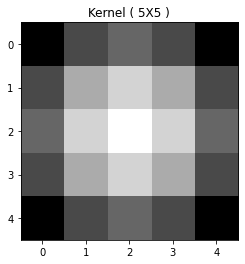

Kernel Shape : (5, 5)


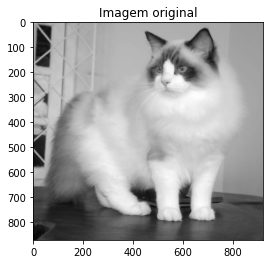

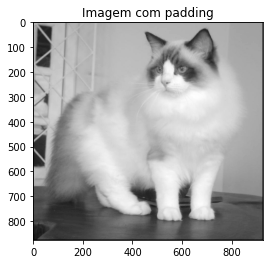

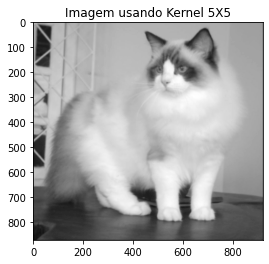

Kernel Shape : (3, 3)
Kernel Shape : (3, 3)


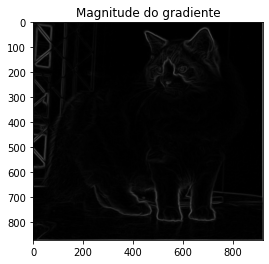

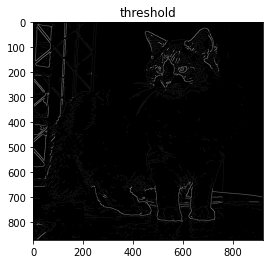

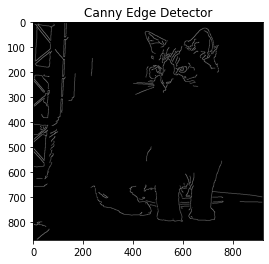

In [21]:
image = cv2.imread("/content/drive/MyDrive/HistogramasPDI/imagens/Ragdoll.jpg")
 
# suavizacao da imagem com o filtro Gaussiano de Kernel 5x5
blurred_image = gaussian_blur(image, kernel_size=5, verbose=True)

# destaque das bordas
edge_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

# calculo do gradiente com o kernel de Sobel
gradient_magnitude, gradient_direction = sobel_edge_detection(blurred_image, edge_filter, convert_to_degree=True, verbose=True)

# supressao de não máximos
nova_imagem = non_max_suppression(gradient_magnitude, gradient_direction, verbose=True)
 
# definicao de qual pixel é fraco para o método de hysteresys
weak = 50

# a nova imagem passa pelo processo de double threshold
nova_imagem = threshold(nova_imagem, 5, 20, weak=weak, verbose=True)
 
# a nova imagem para por hysteresys passando o valor do pixel mais fraco
nova_imagem = hysteresis(nova_imagem, weak)
 
plt.imshow(nova_imagem, cmap='gray')
plt.title("Canny Edge Detector")
plt.show()

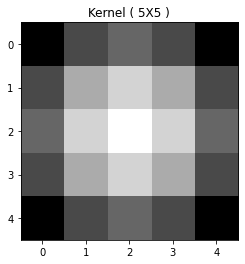

Kernel Shape : (5, 5)


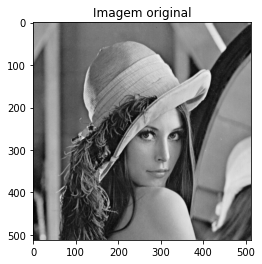

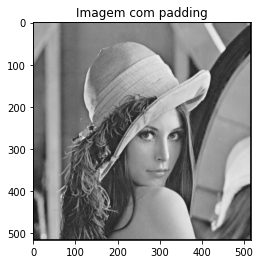

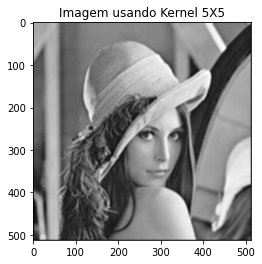

Kernel Shape : (3, 3)
Kernel Shape : (3, 3)


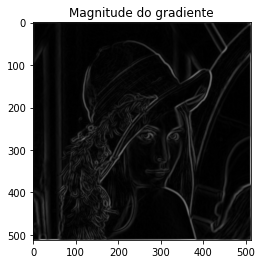

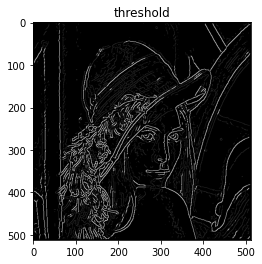

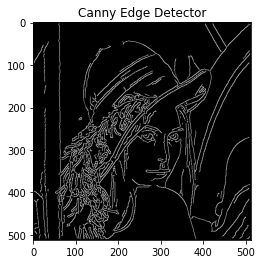

In [22]:
image = cv2.imread("/content/drive/MyDrive/HistogramasPDI/imagens/lena.png")
 
# suavizacao da imagem com o filtro Gaussiano de Kernel 5x5
blurred_image = gaussian_blur(image, kernel_size=5, verbose=True)

# destaque das bordas
edge_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

# calculo do gradiente com o kernel de Sobel
gradient_magnitude, gradient_direction = sobel_edge_detection(blurred_image, edge_filter, convert_to_degree=True, verbose=True)

# supressao de não máximos
nova_imagem = non_max_suppression(gradient_magnitude, gradient_direction, verbose=True)
 
# definicao de qual pixel é fraco para o método de hysteresys
weak = 50

# a nova imagem passa pelo processo de double threshold
nova_imagem = threshold(nova_imagem, 5, 20, weak=weak, verbose=True)
 
# a nova imagem para por hysteresys passando o valor do pixel mais fraco
nova_imagem = hysteresis(nova_imagem, weak)
 
plt.imshow(nova_imagem, cmap='gray')
plt.title("Canny Edge Detector")
plt.show()